   In this notebook we use the cleaned dataset from [DataCleaning](DataCleaning.ipynb) to create features for modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

np.random.seed(123)

plt.style.use("seaborn")

# Features

In [2]:
# Load the dataframe
df = pd.read_csv("./data/df_clean.csv", index_col=0).reset_index(drop=True)
df.head()

,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts,Mark,Stage,Id
0,21417,56,1023,175,-88,-361,-327,1,30,1.0,Back,1
1,21423,83,1019,149,-92,-363,-319,1,30,NaN,Back,1
2,21429,69,1006,116,-88,-366,-325,1,30,NaN,Back,1
3,21436,75,1008,92,-88,-361,-334,1,30,NaN,Back,1
4,21442,81,996,56,-82,-366,-339,1,30,NaN,Back,1


As we discussed previously, we can divide a putt into two stages: swinging the club back and swinging it forward. 

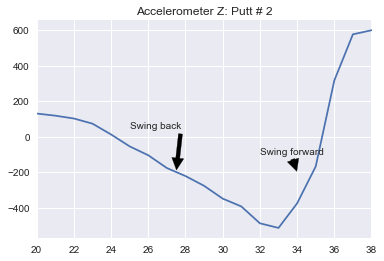

In [3]:
# Plot swing
tmp = df.loc[df.Id == 2, :]


_ = tmp.AZ.plot()
_ = plt.annotate("Swing back", xy=(27.5,-200), xytext=(25,50), arrowprops=dict(facecolor='black', shrink=0.05))
_ = plt.annotate("Swing forward", xy=(34,-200), xytext=(32,-100), arrowprops=dict(facecolor='black', shrink=0.05))
_ = plt.title("Accelerometer Z: Putt # 2")


Our assumption is that only swing forward applies force to a ball, so we will use only this part of the swing for creating independent variables. 

In [4]:
df = df.loc[df.Stage == 'Forward', :]

df.head()

,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts,Mark,Stage,Id
14,21504,12,1108,-444,-92,-367,-334,1,30,2.0,Forward,1
15,21511,32,1120,-392,-91,-363,-318,1,30,NaN,Forward,1
16,21517,-83,972,106,-103,-358,-297,1,30,NaN,Forward,1
17,21523,30,1046,75,-97,-346,-285,1,30,NaN,Forward,1
18,21529,29,1044,381,-89,-352,-274,1,30,NaN,Forward,1


We will use all axes of Accelerometer and Gyroscope in the hope that we can also predict misses that happended to the left or to the right of the hole. 

The strategy is to create many summary variables to use them later with Lasso regularization as a way of feature selection.

For each axis we calculate the follwoing Variables: Range, Min, Max, Average, StDev, Last and Average of recentered observations. To recenter observations we subtract the miminun value $\bar{X} = \sum \frac{x_i - min(X)}{N}$.

Also, because we have one continous motion, we can roughly approximate derivatives as $\frac{X_T - X_0}{\Delta T}$

In [5]:
# Function to calculate variables

def CalcVar(x, ts):
    '''
    Calculates variables based on Series of observations (x) and timestampts (ts). Returns Dictionary.
    
    '''
    
    Max= np.max(x)
    Min= np.min(x)
    Range = Max-Min
    Av = np.mean(x)
    StDev = np.std(x)
    
    AvDem = np.mean(x - Min)
    StDevDem = np.std(x - Min)
    
    Last = x[-1]
    
    Deriv = (x[-1] - x[0])/(ts[-1] - ts[0])
    
    out = pd.Series({"Range":Range, "Max":Max, "Min":Min, "Last":Last, "Mean":Av, "StDev":StDev, 
                                          "MeanD":AvDem, "StDevDem":StDevDem, 'Deriv': Deriv})
    
    
    return out
    

In [6]:
# Test function
x = df.loc[df.Id==3, ['AZ','Time']]
CalcVar(x['AZ'].values, x['Time'].values)

Range       1125.00000
Max          516.00000
Min         -609.00000
Last         516.00000
Mean         -44.80000
StDev        439.48397
MeanD        564.20000
StDevDem     439.48397
Deriv         45.00000
dtype: float64

We also create vector distance representation for each sensor

In [7]:
df['Accel'] = df[['AZ', 'AY', 'AX']].apply(lambda x: np.sqrt(x.iloc[0]**2 + x.iloc[1]**2 + x.iloc[2]**2), axis=1)
df['Gyro'] = df[['GZ', 'GY', 'GX']].apply(lambda x: np.sqrt(x.iloc[0]**2 + x.iloc[1]**2 + x.iloc[2]**2), axis=1)

df.head()

,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts,Mark,Stage,Id,Accel,Gyro
14,21504,12,1108,-444,-92,-367,-334,1,30,2.0,Forward,1,1193.710183,504.687032
15,21511,32,1120,-392,-91,-363,-318,1,30,NaN,Forward,1,1187.050125,491.094696
16,21517,-83,972,106,-103,-358,-297,1,30,NaN,Forward,1,981.279267,476.426280
17,21523,30,1046,75,-97,-346,-285,1,30,NaN,Forward,1,1049.114388,458.639292
18,21529,29,1044,381,-89,-352,-274,1,30,NaN,Forward,1,1111.727485,454.863716


We create a summary table for independent variables by circling through the ids and variables.

In [8]:
# Set variables
var_list = ['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'Accel', 'Gyro']
all_ids = df.Id.unique()

res = pd.DataFrame()

for i in all_ids:
    
    out1 = pd.DataFrame({"Id":i}, index=[i])
    
    for v in var_list:
        tmp =  df.loc[df.Id==i, [v, 'Time']]
        
        t_ = CalcVar(tmp[v].values, tmp['Time'].values)
        t_.index = [v + "_" + sub for sub in t_.index.values] 
        
              
        t_ = pd.DataFrame(t_).transpose()
        t_['Id'] = i
        
        out1 = out1.merge(t_, on ='Id', how = 'left')
    
    res = res.append(out1, ignore_index=True)
        

res.head()

,Id,AX_Range,AX_Max,AX_Min,AX_Last,AX_Mean,AX_StDev,AX_MeanD,AX_StDevDem,AX_Deriv,...,Accel_Deriv,Gyro_Range,Gyro_Max,Gyro_Min,Gyro_Last,Gyro_Mean,Gyro_StDev,Gyro_MeanD,Gyro_StDevDem,Gyro_Deriv
0,1,129.0,46.0,-83.0,46.0,11.000000,43.181786,94.000000,43.181786,1.062500,...,-0.784853,62.675720,504.687032,442.011312,442.011312,471.287054,21.683611,29.275742,21.683611,-1.958616
1,2,173.0,99.0,-74.0,-20.0,26.166667,59.260489,100.166667,59.260489,1.741935,...,-0.839279,43.456776,491.701129,448.244353,448.244353,467.928756,15.838121,19.684403,15.838121,-1.401831
2,3,339.0,291.0,-48.0,53.0,75.400000,116.989914,123.400000,116.989914,4.040000,...,-0.902048,39.061656,495.278709,456.217054,456.217054,475.083052,15.591460,18.865998,15.591460,-1.562466
3,4,96.0,55.0,-41.0,-17.0,8.333333,33.900180,49.333333,33.900180,-1.419355,...,-2.360549,62.198122,502.479850,440.281728,441.196102,463.761472,22.415696,23.479744,22.415696,-1.976895
4,5,227.0,231.0,4.0,64.0,73.750000,74.511325,69.750000,74.511325,0.727273,...,-0.088372,65.791242,509.858804,444.067562,447.086121,470.240758,22.349601,26.173195,22.349601,-1.426652


# Add distance and Response variable

In [9]:
# Read response and distance

resp = pd.read_csv("../1_DataCollect/data/response.csv")
resp.columns.values[0] = 'Id'
resp.head()

,Id,Distance,Result
0,1,2,0
1,2,2,1
2,3,2,1
3,4,2,0
4,5,2,1


In [11]:
# Merge

df = resp.merge(res, on='Id', how='left')
df.head()

,Id,Distance,Result,AX_Range,AX_Max,AX_Min,AX_Last,AX_Mean,AX_StDev,AX_MeanD,...,Accel_Deriv,Gyro_Range,Gyro_Max,Gyro_Min,Gyro_Last,Gyro_Mean,Gyro_StDev,Gyro_MeanD,Gyro_StDevDem,Gyro_Deriv
0,1,2,0,129.0,46.0,-83.0,46.0,11.000000,43.181786,94.000000,...,-0.784853,62.675720,504.687032,442.011312,442.011312,471.287054,21.683611,29.275742,21.683611,-1.958616
1,2,2,1,173.0,99.0,-74.0,-20.0,26.166667,59.260489,100.166667,...,-0.839279,43.456776,491.701129,448.244353,448.244353,467.928756,15.838121,19.684403,15.838121,-1.401831
2,3,2,1,339.0,291.0,-48.0,53.0,75.400000,116.989914,123.400000,...,-0.902048,39.061656,495.278709,456.217054,456.217054,475.083052,15.591460,18.865998,15.591460,-1.562466
3,4,2,0,96.0,55.0,-41.0,-17.0,8.333333,33.900180,49.333333,...,-2.360549,62.198122,502.479850,440.281728,441.196102,463.761472,22.415696,23.479744,22.415696,-1.976895
4,5,2,1,227.0,231.0,4.0,64.0,73.750000,74.511325,69.750000,...,-0.088372,65.791242,509.858804,444.067562,447.086121,470.240758,22.349601,26.173195,22.349601,-1.426652


In [12]:
df.shape

(250, 75)

# Train and Test set

We use stratification by Distance and Result to make sure that our datasets are balanced. 

In [13]:
# Train/test
train, test  = train_test_split(df, test_size=0.3, random_state=123, stratify=df[['Result', 'Distance']])

In [14]:
print(train.shape)
print(test.shape)

(175, 75)
(75, 75)


Remove distance in feet

In [16]:
train.head()

,Id,Distance,Result,AX_Range,AX_Max,AX_Min,AX_Last,AX_Mean,AX_StDev,AX_MeanD,...,Accel_Deriv,Gyro_Range,Gyro_Max,Gyro_Min,Gyro_Last,Gyro_Mean,Gyro_StDev,Gyro_MeanD,Gyro_StDevDem,Gyro_Deriv
146,47,4,0,374.0,254.0,-120.0,254.0,52.400000,150.409574,172.400000,...,4.609239,75.811889,513.345887,437.533999,437.533999,482.378497,29.464996,44.844498,29.464996,-2.999645
117,18,4,1,166.0,91.0,-75.0,18.0,28.000000,57.982756,103.000000,...,-0.248448,59.785414,512.903500,453.118086,453.118086,480.624084,24.500811,27.505998,24.500811,-2.391417
201,2,6,1,173.0,99.0,-74.0,-20.0,26.166667,59.260489,100.166667,...,-0.839279,43.456776,491.701129,448.244353,448.244353,467.928756,15.838121,19.684403,15.838121,-1.401831
156,7,5,1,131.0,129.0,-2.0,60.0,80.833333,44.356197,82.833333,...,-1.748867,41.781974,498.776503,456.994530,461.906917,476.257587,14.670055,19.263058,14.670055,-1.189341
152,3,5,0,339.0,291.0,-48.0,53.0,75.400000,116.989914,123.400000,...,-0.902048,39.061656,495.278709,456.217054,456.217054,475.083052,15.591460,18.865998,15.591460,-1.562466


In [17]:
# Pickle for future use
test.to_pickle("./data/test.pkl")
train.to_pickle("./data/train.pkl")

In [18]:
# Explore variable to see if there is nothing outstanding

df.describe().transpose().head(26)

,count,mean,std,min,25%,50%,75%,max
Id,250.0,25.500000,14.459818,1.000000,13.000000,25.500000,38.000000,50.000000
Distance,250.0,4.000000,1.417051,2.000000,3.000000,4.000000,5.000000,6.000000
Result,250.0,0.520000,0.500602,0.000000,0.000000,1.000000,1.000000,1.000000
AX_Range,250.0,228.040000,127.865071,50.000000,131.000000,194.500000,275.000000,651.000000
AX_Max,250.0,177.400000,105.262724,23.000000,109.000000,147.500000,246.000000,567.000000
AX_Min,250.0,-50.640000,62.501650,-254.000000,-90.000000,-36.000000,-2.000000,72.000000
AX_Last,250.0,69.740000,64.160883,-43.000000,23.000000,66.500000,108.000000,258.000000
AX_Mean,250.0,50.517024,45.442724,-84.800000,26.166667,53.833333,86.428571,150.000000
AX_StDev,250.0,79.148999,48.316034,20.672042,44.356197,62.795503,87.830291,234.405631
AX_MeanD,250.0,101.157024,53.289851,21.000000,66.000000,92.100000,123.400000,305.200000


In [19]:
df.describe().transpose().tail(len(df.columns.values)-26)

,count,mean,std,min,25%,50%,75%,max
AZ_StDev,250.0,475.426235,123.962402,276.493319,385.497325,452.208853,528.372823,849.219171
AZ_MeanD,250.0,617.723635,171.765085,326.000000,492.166667,605.416667,708.166667,1156.000000
AZ_StDevDem,250.0,475.426235,123.962402,276.493319,385.497325,452.208853,528.372823,849.219171
AZ_Deriv,250.0,41.968348,16.092493,13.929825,30.052632,39.616129,51.560000,84.480000
GX_Range,250.0,19.380000,5.893601,4.000000,15.000000,19.000000,24.000000,35.000000
GX_Max,250.0,-84.500000,5.249785,-97.000000,-88.000000,-85.000000,-82.000000,-71.000000
GX_Min,250.0,-103.880000,3.986120,-112.000000,-107.000000,-103.000000,-101.000000,-94.000000
GX_Last,250.0,-99.780000,5.226938,-110.000000,-104.000000,-100.000000,-95.000000,-82.000000
GX_Mean,250.0,-95.499365,3.239862,-105.833333,-97.833333,-95.350000,-93.714286,-88.333333
GX_StDev,250.0,6.932017,2.153092,1.673320,5.161395,6.631938,8.558621,12.009996
